In [52]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve,GridSearchCV

data = pd.read_csv('~/Desktop/project2/data.csv')
data.shape

(101766, 50)

In [53]:
#Remove "[", ")", ">", and "<"
data['age']=data['age'].str.replace('[','')
data['age']=data['age'].str.replace(')','')
data['weight']=data['weight'].str.replace('[','')
data['weight']=data['weight'].str.replace(')','')
data['max_glu_serum']=data['max_glu_serum'].str.replace('>','greater_than_')
data['A1Cresult']=data['A1Cresult'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('<','smaller_than_')


In [54]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443842070,443842136,443842340,443842778,443847176,443847548,443847782,443854148,443857166,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,140199494,181593374,120975314,86472243,50375628,100162476,74694222,41088789,31693671,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,...,60-70,70-80,80-90,80-90,60-70,70-80,80-90,70-80,80-90,70-80
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6


# Missing Values
Want to drop medical_specialty,weight ,payer_code for sure

In [55]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [56]:

#Create new variable 'readmitted_yes' for binary classification
data['readmitted_yes']= (data['readmitted'] == 'greater_than_30').astype(int) +  (data['readmitted'] == 'smaller_than_30').astype(int) 

In [57]:
data.groupby(["readmitted_yes"])['readmitted_yes'].count()

readmitted_yes
0    54864
1    46902
Name: readmitted_yes, dtype: int64

In [58]:
# Encode change column, gender, diabetesMed column
# ch to Yes to 1, No to 1 
# gender: Male to 1, Female to 0
# DiabetesMed: Yed to 1, No to 0

In [59]:
data['change'] = data['change'].replace('Ch', 1)
data['change'] = data['change'].replace('No', 0)
data['gender'] = data['gender'].replace('Male', 1)
data['gender'] = data['gender'].replace('Female', 0)
data['diabetesMed'] = data['diabetesMed'].replace('Yes', 1)
data['diabetesMed'] = data['diabetesMed'].replace('No', 0)


In [60]:
# there are 24 features of medicine,which indicates whether the drug 
# was prescribed or there was a change in the dosage
# Possible values: “up” if the dosage was increased during the encounter, 
# “down” if the dosage was decreased, “steady” if the dosage did not change,
# and “no” if the drug was not prescribed

meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin',
        'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone',
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

In [61]:
# Encode Up to 3, steady to 2, down to 1, no to 0
for col in meds:
    data[col] = data[col].replace('No', 0)
    data[col] = data[col].replace('Steady', 2)
    data[col] = data[col].replace('Up', 3)
    data[col] = data[col].replace('Down', 1)

In [62]:
data.groupby(['age'])['age'].count()

age
0-10        161
10-20       691
20-30      1657
30-40      3775
40-50      9685
50-60     17256
60-70     22483
70-80     26068
80-90     17197
90-100     2793
Name: age, dtype: int64

In [63]:

# Convert age to numerical, take the mid point of each interval, 5,15,25, etc

data['age'] = data['age'].replace('0-10', 5)
data['age'] = data['age'].replace('10-20', 15)
data['age'] = data['age'].replace('20-30', 25)
data['age'] = data['age'].replace('30-40', 35)
data['age'] = data['age'].replace('40-50', 45)
data['age'] = data['age'].replace('50-60', 55)
data['age'] = data['age'].replace('60-70', 65)
data['age'] = data['age'].replace('70-80', 75)
data['age'] = data['age'].replace('80-90', 85)
data['age'] = data['age'].replace('90-100', 95)

In [64]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443842070,443842136,443842340,443842778,443847176,443847548,443847782,443854148,443857166,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,140199494,181593374,120975314,86472243,50375628,100162476,74694222,41088789,31693671,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,0,1,1,1,1,1,0,0,...,0,0,0,1,0,1,0,1,0,1
age,5,15,25,35,45,55,65,75,85,95,...,65,75,85,85,65,75,85,75,85,75
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6


In [65]:
# convert examide and citoglipton to binary
data.groupby(['examide'])['examide'].count()
data.groupby(['citoglipton'])['citoglipton'].count()
# No need, all values are NO, just drop them

citoglipton
No    101766
Name: citoglipton, dtype: int64

In [66]:
# Drop payer_code, weight, medical_specialty, readmitted, examide, citoglipton
del_columns = ['weight', 'payer_code', 'medical_specialty','examide','citoglipton','readmitted']
data.drop(del_columns, inplace=True, axis=1)


In [67]:
del_col = ["encounter_id","patient_nbr"]
data.drop(del_col, inplace=True, axis=1)

In [68]:
df = data

In [69]:
# Recode diag1, diag2, diag3

df.loc[df['diag_1'].str.contains('V'), ['diag_1']] = "SUPPLEMENTARY"
df.loc[df['diag_2'].str.contains('V'), ['diag_2']] = "SUPPLEMENTARY"
df.loc[df['diag_3'].str.contains('V'), ['diag_3']] = "SUPPLEMENTARY"

df.loc[df['diag_1'].str.contains('E'), ['diag_1']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_2'].str.contains('E'), ['diag_2']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_3'].str.contains('E'), ['diag_3']] = "SUPPLEMENTARY_EXTERNAL"

df['diag_1'] = df['diag_1'].replace('?', "NONE")
df['diag_2'] = df['diag_2'].replace('?', "NONE")
df['diag_3'] = df['diag_3'].replace('?', "NONE")

In [70]:
#df['diag_1'] = pd.to_numeric(df['diag_1'], errors='ignore')
#df['diag_2']= pd.to_numeric(df['diag_2'], errors='ignore')
#df['diag_3']= pd.to_numeric(df['diag_3'], errors='ignore')

In [71]:
# Helper function to convert str to float
def change_to_num(col):
    res = []
    for i in col:
        if i not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
            res.append(float(i))
        else:
            res.append(i)
    return res
        

In [72]:
df['diag_1'] = change_to_num(df['diag_1'])
df['diag_2'] = change_to_num(df['diag_2'])
df['diag_3'] = change_to_num(df['diag_3'])

In [73]:
df['diag_1']

0                         250.83
1                            276
2                            648
3                              8
4                            197
5                            414
6                            414
7                            428
8                            398
9                            434
10                         250.7
11                           157
12                           428
13                           428
14                           518
15                           999
16                           410
17                           682
18                           402
19                           737
20                           410
21                           572
22                           410
23        SUPPLEMENTARY_EXTERNAL
24                           189
25                           786
26                           427
27                           996
28                           277
29                           428
          

In [74]:
new_diag_1

['ENDO_NUTRI_METABOLIC',
 'ENDO_NUTRI_METABOLIC',
 'PREGNANCY',
 'INFECTIOUS_PARASTIC_DISEASE',
 'NEOPLASMS',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'ENDO_NUTRI_METABOLIC',
 'NEOPLASMS',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'RESPIRATORY_SYSTEM_DISEASE',
 'INJURY_POISONING',
 'CIRCULATORY_SYSTEM_DISEASE',
 'SKIN_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'MUSCULOSKELETAL_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'DIGESTIVE_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'SUPPLEMENTARY_EXTERNAL',
 'NEOPLASMS',
 'ILL_DEFINED_COND',
 'CIRCULATORY_SYSTEM_DISEASE',
 'INJURY_POISONING',
 'ENDO_NUTRI_METABOLIC',
 'CIRCULATORY_SYSTEM_DISEASE',
 'GENETOURINARY_SYSTEM_DISEASE',
 'RESPIRATORY_SYSTEM_DISEASE',
 'INJURY_POISONING',
 'RESPIRATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'NEOPLASMS',
 'RESPIRATORY_S

In [75]:
new_diag_1 = []
for index, row in df.iterrows():
    if row['diag_1'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_1'] >= 1 and row['diag_1'] <= 139):
            new_diag_1.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_1'] >= 140 and row['diag_1'] <= 239):
            new_diag_1.append("NEOPLASMS")
        elif (row['diag_1'] >= 240 and row['diag_1'] <= 279):
            new_diag_1.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_1'] >= 280 and row['diag_1'] <= 289):
            new_diag_1.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_1'] >= 290 and row['diag_1'] <= 319):
            new_diag_1.append("MENTAL_DISORDER")
        elif (row['diag_1'] >= 320 and row['diag_1'] <= 389):
            new_diag_1.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_1'] >= 390 and row['diag_1'] <= 459):
            new_diag_1.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 460 and row['diag_1'] <= 519):
            new_diag_1.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 520 and row['diag_1'] <= 579):
            new_diag_1.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 580 and row['diag_1'] <= 629):
            new_diag_1.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 630 and row['diag_1'] <= 679):
            new_diag_1.append("PREGNANCY")
        elif (row['diag_1'] >= 680 and row['diag_1'] <= 709):
            new_diag_1.append("SKIN_DISEASE")
        elif (row['diag_1'] >= 710 and row['diag_1'] <= 739):
            new_diag_1.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 740 and row['diag_1'] <= 759):
            new_diag_1.append("CONGENITAL_ANOMALIES")
        elif (row['diag_1'] >= 760 and row['diag_1'] <= 779):
            new_diag_1.append("PERINATAL_PERIOD")
        elif (row['diag_1'] >= 780 and row['diag_1'] <= 799):
            new_diag_1.append("ILL_DEFINED_COND")
        elif (row['diag_1'] >= 800 and row['diag_1'] <= 999):
            new_diag_1.append("INJURY_POISONING")
    else:
        new_diag_1.append(row['diag_1'])


In [76]:
df['diag_1'] = pd.Series(new_diag_1)

In [77]:
new_diag_2 = []
for index, row in df.iterrows():
    if row['diag_2'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_2'] >= 1 and row['diag_2'] <= 139):
            new_diag_2.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_2'] >= 140 and row['diag_2'] <= 239):
            new_diag_2.append("NEOPLASMS")
        elif (row['diag_2'] >= 240 and row['diag_2'] <= 279):
            new_diag_2.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_2'] >= 280 and row['diag_2'] <= 289):
            new_diag_2.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_2'] >= 290 and row['diag_2'] <= 319):
            new_diag_2.append("MENTAL_DISORDER")
        elif (row['diag_2'] >= 320 and row['diag_2'] <= 389):
            new_diag_2.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_2'] >= 390 and row['diag_2'] <= 459):
            new_diag_2.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 460 and row['diag_2'] <= 519):
            new_diag_2.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 520 and row['diag_2'] <= 579):
            new_diag_2.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 580 and row['diag_2'] <= 629):
            new_diag_2.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 630 and row['diag_2'] <= 679):
            new_diag_2.append("PREGNANCY")
        elif (row['diag_2'] >= 680 and row['diag_2'] <= 709):
            new_diag_2.append("SKIN_DISEASE")
        elif (row['diag_2'] >= 710 and row['diag_2'] <= 739):
            new_diag_2.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 740 and row['diag_2'] <= 759):
            new_diag_2.append("CONGENITAL_ANOMALIES")
        elif (row['diag_2'] >= 760 and row['diag_2'] <= 779):
            new_diag_2.append("PERINATAL_PERIOD")
        elif (row['diag_2'] >= 780 and row['diag_2'] <= 799):
            new_diag_2.append("ILL_DEFINED_COND")
        elif (row['diag_2'] >= 800 and row['diag_2'] <= 999):
            new_diag_2.append("INJURY_POISONING")
    else:
        new_diag_2.append(row['diag_2'])

df['diag_2'] = pd.Series(new_diag_2)

In [78]:
new_diag_3 = []
for index, row in df.iterrows():
    if row['diag_3'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_3'] >= 1 and row['diag_3'] <= 139):
            new_diag_3.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_3'] >= 140 and row['diag_3'] <= 239):
            new_diag_3.append("NEOPLASMS")
        elif (row['diag_3'] >= 240 and row['diag_3'] <= 279):
            new_diag_3.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_3'] >= 280 and row['diag_3'] <= 289):
            new_diag_3.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_3'] >= 290 and row['diag_3'] <= 319):
            new_diag_3.append("MENTAL_DISORDER")
        elif (row['diag_3'] >= 320 and row['diag_3'] <= 389):
            new_diag_3.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_3'] >= 390 and row['diag_3'] <= 459):
            new_diag_3.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 460 and row['diag_3'] <= 519):
            new_diag_3.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 520 and row['diag_3'] <= 579):
            new_diag_3.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 580 and row['diag_3'] <= 629):
            new_diag_3.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 630 and row['diag_3'] <= 679):
            new_diag_3.append("PREGNANCY")
        elif (row['diag_3'] >= 680 and row['diag_3'] <= 709):
            new_diag_3.append("SKIN_DISEASE")
        elif (row['diag_3'] >= 710 and row['diag_3'] <= 739):
            new_diag_3.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 740 and row['diag_3'] <= 759):
            new_diag_3.append("CONGENITAL_ANOMALIES")
        elif (row['diag_3'] >= 760 and row['diag_3'] <= 779):
            new_diag_3.append("PERINATAL_PERIOD")
        elif (row['diag_3'] >= 780 and row['diag_3'] <= 799):
            new_diag_3.append("ILL_DEFINED_COND")
        elif (row['diag_3'] >= 800 and row['diag_3'] <= 999):
            new_diag_3.append("INJURY_POISONING")
    else:
        new_diag_3.append(row['diag_3'])

df['diag_3'] = pd.Series(new_diag_3)

In [28]:
df.to_csv("~/Desktop/recode_data.csv",index=False)

In [79]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,0,1,1,1,1,1,0,0,...,0,0,0,1,0,1,0,1,0,1
age,5,15,25,35,45,55,65,75,85,95,...,65,75,85,85,65,75,85,75,85,75
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,...,46,21,76,1,45,51,33,53,45,13
num_procedures,0,0,5,1,0,6,1,0,2,3,...,6,1,1,0,1,0,3,0,2,3
num_medications,1,18,13,16,8,16,21,12,28,18,...,17,16,22,15,25,16,18,9,21,3


In [80]:
df.groupby(['gender'])['gender'].count()

gender
0                  54708
1                  47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [81]:
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

In [82]:
df.groupby(['gender'])['gender'].count()

gender
0    54708
1    47055
Name: gender, dtype: int64

In [83]:
df_2 = pd.get_dummies(df, columns=['gender','diag_1','diag_2','diag_3','max_glu_serum',
                                   'A1Cresult','race',
                                   'admission_type_id',
                                   'discharge_disposition_id','admission_source_id'], drop_first=True)

In [84]:
#Construct predicted variable 'readmitted_yes' and predictors
Y=df_2['readmitted_yes']
X=df_2.drop('readmitted_yes',axis=1)
seed = 7
test_size = 0.33
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [85]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

C:\Users\16476\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [86]:
#Define function for tuning the number of estimators
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        dtrain = xgb.DMatrix(X_train, label=y_train)
        xgb_param = alg.get_xgb_params()
        xgtrain = dtrain
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nthe best number of trees is ", cvresult.shape[0])
    print("\nModel Report")
    print ("Accuracy : %.4g" % sklearn.metrics.accuracy_score(y_train, dtrain_predictions))
    print ("AUC Score (Train): %f" % sklearn.metrics.roc_auc_score(y_train, dtrain_predprob))
                    
    xgb.plot_importance(alg, max_num_features=20)


the best number of trees is  273

Model Report
Accuracy : 0.6833
AUC Score (Train): 0.751455


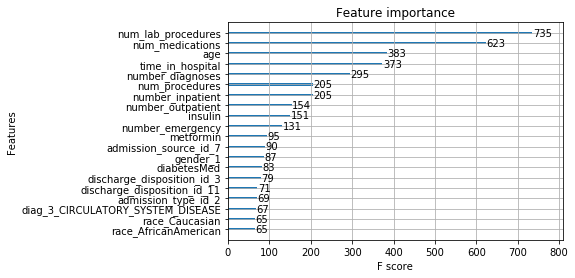

In [46]:
#Tune the number of estimators
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, Y_train)

In [48]:
#Tune max_depth and min_child_weight
param_test1 = {
 'max_depth':range(2,8,2),
 'min_child_weight':range(0,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=273, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_

{'max_depth': 4, 'min_child_weight': 4}

In [49]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[3,4,5]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=273, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.best_params_

{'max_depth': 5, 'min_child_weight': 3}

In [50]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=273, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_


{'gamma': 0.0}

In [87]:
param_test4 = {
 'gamma':[i*2/100.0 for i in range(0,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=273, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_


{'gamma': 0.0}

C:\Users\16476\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



the best number of trees is  240

Model Report
Accuracy : 0.6766
AUC Score (Train): 0.743434


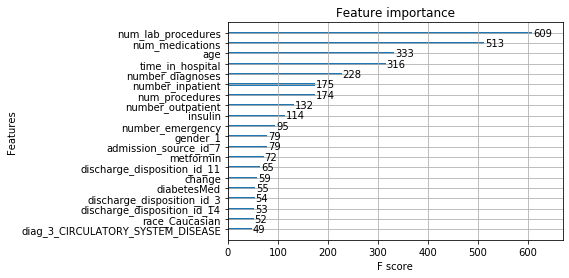

In [88]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X_train, Y_train)

In [89]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=240, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.7}

In [91]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=240, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_

{'reg_alpha': 1}

In [96]:
param_test7 = {
 'reg_alpha':[1, 5, 10, 20]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=240, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.9, reg_alpha=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,Y_train)
gsearch7.best_params_

{'reg_alpha': 5}

C:\Users\16476\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



the best number of trees is  248

Model Report
Accuracy : 0.6742
AUC Score (Train): 0.738371


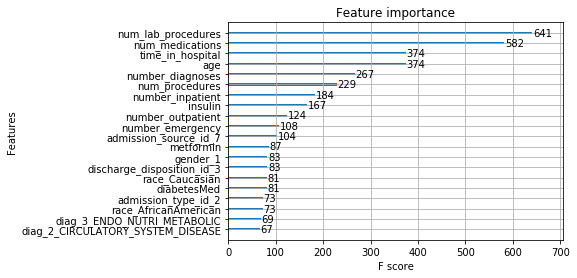

In [97]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.9,
 reg_alpha=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, Y_train)

C:\Users\16476\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



the best number of trees is  2600

Model Report
Accuracy : 0.6763
AUC Score (Train): 0.741276


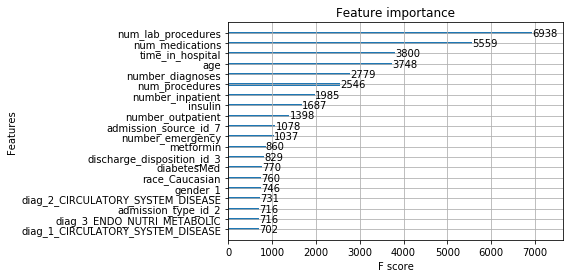

In [98]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.9,
 reg_alpha=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, X_train, Y_train)

In [99]:
model_param = {'max_depth': 5,'min_child_weight': 3, 'eta': 0.01, 'gamma': 0, 'subsample': 0.7,'colsample_bytree': 0.9,'reg_alpha': 5,'objective': 'binary:logistic','nthread': 4,'scale_pos_weight': 1,'seed': 27,'eval_metric': 'auc'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round=2600
model = xgb.train(model_param, dtrain, num_round, evallist)

[0]	eval-auc:0.665719	train-auc:0.66169
[1]	eval-auc:0.671502	train-auc:0.669602
[2]	eval-auc:0.677192	train-auc:0.673473
[3]	eval-auc:0.678784	train-auc:0.676203
[4]	eval-auc:0.677638	train-auc:0.675956
[5]	eval-auc:0.679	train-auc:0.677076
[6]	eval-auc:0.679293	train-auc:0.677407
[7]	eval-auc:0.67904	train-auc:0.677005
[8]	eval-auc:0.679152	train-auc:0.677365
[9]	eval-auc:0.680165	train-auc:0.678016
[10]	eval-auc:0.680116	train-auc:0.677852
[11]	eval-auc:0.679689	train-auc:0.677355
[12]	eval-auc:0.679449	train-auc:0.677205
[13]	eval-auc:0.679281	train-auc:0.67726
[14]	eval-auc:0.679641	train-auc:0.677768
[15]	eval-auc:0.679538	train-auc:0.677941
[16]	eval-auc:0.679222	train-auc:0.677658
[17]	eval-auc:0.679141	train-auc:0.677673
[18]	eval-auc:0.679053	train-auc:0.677677
[19]	eval-auc:0.67913	train-auc:0.677648
[20]	eval-auc:0.679039	train-auc:0.677683
[21]	eval-auc:0.678753	train-auc:0.677467
[22]	eval-auc:0.678604	train-auc:0.677295
[23]	eval-auc:0.678541	train-auc:0.677483
[24]	eval

[195]	eval-auc:0.685819	train-auc:0.687175
[196]	eval-auc:0.685849	train-auc:0.687212
[197]	eval-auc:0.685925	train-auc:0.68728
[198]	eval-auc:0.685949	train-auc:0.687294
[199]	eval-auc:0.685977	train-auc:0.687322
[200]	eval-auc:0.686001	train-auc:0.687336
[201]	eval-auc:0.686078	train-auc:0.687428
[202]	eval-auc:0.686132	train-auc:0.687491
[203]	eval-auc:0.686174	train-auc:0.687538
[204]	eval-auc:0.686206	train-auc:0.687573
[205]	eval-auc:0.686274	train-auc:0.687623
[206]	eval-auc:0.686315	train-auc:0.687711
[207]	eval-auc:0.686367	train-auc:0.687754
[208]	eval-auc:0.686402	train-auc:0.687784
[209]	eval-auc:0.686483	train-auc:0.687879
[210]	eval-auc:0.686551	train-auc:0.687947
[211]	eval-auc:0.68658	train-auc:0.687975
[212]	eval-auc:0.686632	train-auc:0.68804
[213]	eval-auc:0.686734	train-auc:0.688165
[214]	eval-auc:0.686782	train-auc:0.688209
[215]	eval-auc:0.686845	train-auc:0.688268
[216]	eval-auc:0.686912	train-auc:0.688332
[217]	eval-auc:0.686976	train-auc:0.688375
[218]	eval-auc

[387]	eval-auc:0.693265	train-auc:0.696027
[388]	eval-auc:0.693284	train-auc:0.696068
[389]	eval-auc:0.693329	train-auc:0.696116
[390]	eval-auc:0.693379	train-auc:0.696229
[391]	eval-auc:0.693378	train-auc:0.696271
[392]	eval-auc:0.693405	train-auc:0.696351
[393]	eval-auc:0.69345	train-auc:0.69639
[394]	eval-auc:0.693479	train-auc:0.696426
[395]	eval-auc:0.693504	train-auc:0.696482
[396]	eval-auc:0.693523	train-auc:0.6965
[397]	eval-auc:0.693541	train-auc:0.696567
[398]	eval-auc:0.693572	train-auc:0.696602
[399]	eval-auc:0.693605	train-auc:0.696681
[400]	eval-auc:0.693643	train-auc:0.696737
[401]	eval-auc:0.693663	train-auc:0.696772
[402]	eval-auc:0.693671	train-auc:0.696782
[403]	eval-auc:0.693704	train-auc:0.696832
[404]	eval-auc:0.693727	train-auc:0.69686
[405]	eval-auc:0.693767	train-auc:0.696892
[406]	eval-auc:0.693792	train-auc:0.696913
[407]	eval-auc:0.693805	train-auc:0.696924
[408]	eval-auc:0.693824	train-auc:0.696949
[409]	eval-auc:0.693855	train-auc:0.696989
[410]	eval-auc:0

[579]	eval-auc:0.697456	train-auc:0.703087
[580]	eval-auc:0.697468	train-auc:0.703104
[581]	eval-auc:0.697513	train-auc:0.703159
[582]	eval-auc:0.697517	train-auc:0.703183
[583]	eval-auc:0.697562	train-auc:0.703231
[584]	eval-auc:0.697573	train-auc:0.703263
[585]	eval-auc:0.697586	train-auc:0.703292
[586]	eval-auc:0.697599	train-auc:0.703318
[587]	eval-auc:0.697636	train-auc:0.703348
[588]	eval-auc:0.697649	train-auc:0.703367
[589]	eval-auc:0.697661	train-auc:0.703378
[590]	eval-auc:0.697677	train-auc:0.703417
[591]	eval-auc:0.69769	train-auc:0.703454
[592]	eval-auc:0.697714	train-auc:0.703487
[593]	eval-auc:0.697728	train-auc:0.703539
[594]	eval-auc:0.69774	train-auc:0.703547
[595]	eval-auc:0.697757	train-auc:0.703569
[596]	eval-auc:0.697764	train-auc:0.703579
[597]	eval-auc:0.697785	train-auc:0.703619
[598]	eval-auc:0.697809	train-auc:0.703661
[599]	eval-auc:0.697843	train-auc:0.703712
[600]	eval-auc:0.697854	train-auc:0.703721
[601]	eval-auc:0.697854	train-auc:0.703751
[602]	eval-au

[771]	eval-auc:0.699987	train-auc:0.708466
[772]	eval-auc:0.699992	train-auc:0.708496
[773]	eval-auc:0.700007	train-auc:0.708512
[774]	eval-auc:0.70002	train-auc:0.708558
[775]	eval-auc:0.700024	train-auc:0.70858
[776]	eval-auc:0.700028	train-auc:0.70859
[777]	eval-auc:0.70003	train-auc:0.708629
[778]	eval-auc:0.700032	train-auc:0.708642
[779]	eval-auc:0.700045	train-auc:0.708685
[780]	eval-auc:0.700058	train-auc:0.708718
[781]	eval-auc:0.700065	train-auc:0.708748
[782]	eval-auc:0.70007	train-auc:0.708763
[783]	eval-auc:0.700087	train-auc:0.708797
[784]	eval-auc:0.70012	train-auc:0.70884
[785]	eval-auc:0.700143	train-auc:0.708888
[786]	eval-auc:0.700178	train-auc:0.708919
[787]	eval-auc:0.700185	train-auc:0.708933
[788]	eval-auc:0.700187	train-auc:0.708953
[789]	eval-auc:0.700197	train-auc:0.70898
[790]	eval-auc:0.700204	train-auc:0.708996
[791]	eval-auc:0.700209	train-auc:0.709015
[792]	eval-auc:0.700213	train-auc:0.70904
[793]	eval-auc:0.700226	train-auc:0.709083
[794]	eval-auc:0.700

[963]	eval-auc:0.701539	train-auc:0.713043
[964]	eval-auc:0.701551	train-auc:0.713075
[965]	eval-auc:0.701556	train-auc:0.713098
[966]	eval-auc:0.70156	train-auc:0.713113
[967]	eval-auc:0.701567	train-auc:0.713136
[968]	eval-auc:0.701587	train-auc:0.713166
[969]	eval-auc:0.70159	train-auc:0.713173
[970]	eval-auc:0.701602	train-auc:0.713184
[971]	eval-auc:0.7016	train-auc:0.713198
[972]	eval-auc:0.701615	train-auc:0.713228
[973]	eval-auc:0.701619	train-auc:0.713246
[974]	eval-auc:0.701626	train-auc:0.71326
[975]	eval-auc:0.701634	train-auc:0.713295
[976]	eval-auc:0.701639	train-auc:0.713315
[977]	eval-auc:0.701641	train-auc:0.713329
[978]	eval-auc:0.701654	train-auc:0.713345
[979]	eval-auc:0.701658	train-auc:0.713374
[980]	eval-auc:0.701661	train-auc:0.713393
[981]	eval-auc:0.701667	train-auc:0.713407
[982]	eval-auc:0.701677	train-auc:0.713429
[983]	eval-auc:0.701703	train-auc:0.713481
[984]	eval-auc:0.701699	train-auc:0.713513
[985]	eval-auc:0.701706	train-auc:0.713521
[986]	eval-auc:0

[1151]	eval-auc:0.702758	train-auc:0.71704
[1152]	eval-auc:0.702766	train-auc:0.71706
[1153]	eval-auc:0.70277	train-auc:0.717075
[1154]	eval-auc:0.702771	train-auc:0.7171
[1155]	eval-auc:0.702776	train-auc:0.717116
[1156]	eval-auc:0.702777	train-auc:0.717119
[1157]	eval-auc:0.702776	train-auc:0.717146
[1158]	eval-auc:0.702779	train-auc:0.717159
[1159]	eval-auc:0.702787	train-auc:0.717185
[1160]	eval-auc:0.702792	train-auc:0.717198
[1161]	eval-auc:0.702805	train-auc:0.717217
[1162]	eval-auc:0.702813	train-auc:0.717234
[1163]	eval-auc:0.702816	train-auc:0.717249
[1164]	eval-auc:0.702818	train-auc:0.717269
[1165]	eval-auc:0.702808	train-auc:0.717292
[1166]	eval-auc:0.702809	train-auc:0.717316
[1167]	eval-auc:0.702831	train-auc:0.717355
[1168]	eval-auc:0.702832	train-auc:0.717374
[1169]	eval-auc:0.702831	train-auc:0.71738
[1170]	eval-auc:0.702834	train-auc:0.717408
[1171]	eval-auc:0.702847	train-auc:0.717429
[1172]	eval-auc:0.702852	train-auc:0.717457
[1173]	eval-auc:0.702858	train-auc:0.7

[1339]	eval-auc:0.703679	train-auc:0.72075
[1340]	eval-auc:0.70368	train-auc:0.720773
[1341]	eval-auc:0.703684	train-auc:0.720782
[1342]	eval-auc:0.703693	train-auc:0.720809
[1343]	eval-auc:0.7037	train-auc:0.720843
[1344]	eval-auc:0.703706	train-auc:0.720871
[1345]	eval-auc:0.703703	train-auc:0.720893
[1346]	eval-auc:0.703706	train-auc:0.720912
[1347]	eval-auc:0.703708	train-auc:0.720919
[1348]	eval-auc:0.703724	train-auc:0.72094
[1349]	eval-auc:0.703732	train-auc:0.720975
[1350]	eval-auc:0.703735	train-auc:0.720992
[1351]	eval-auc:0.703747	train-auc:0.721026
[1352]	eval-auc:0.703764	train-auc:0.721057
[1353]	eval-auc:0.703765	train-auc:0.72109
[1354]	eval-auc:0.703767	train-auc:0.721117
[1355]	eval-auc:0.703764	train-auc:0.721134
[1356]	eval-auc:0.703766	train-auc:0.721155
[1357]	eval-auc:0.703773	train-auc:0.72118
[1358]	eval-auc:0.703776	train-auc:0.721196
[1359]	eval-auc:0.70378	train-auc:0.721202
[1360]	eval-auc:0.703786	train-auc:0.721239
[1361]	eval-auc:0.703786	train-auc:0.721

[1527]	eval-auc:0.704222	train-auc:0.724214
[1528]	eval-auc:0.70422	train-auc:0.724235
[1529]	eval-auc:0.704223	train-auc:0.724258
[1530]	eval-auc:0.704235	train-auc:0.72428
[1531]	eval-auc:0.704231	train-auc:0.724302
[1532]	eval-auc:0.704241	train-auc:0.724321
[1533]	eval-auc:0.704241	train-auc:0.724329
[1534]	eval-auc:0.704249	train-auc:0.724342
[1535]	eval-auc:0.70425	train-auc:0.724349
[1536]	eval-auc:0.70425	train-auc:0.724353
[1537]	eval-auc:0.704248	train-auc:0.724379
[1538]	eval-auc:0.704251	train-auc:0.724395
[1539]	eval-auc:0.704252	train-auc:0.724416
[1540]	eval-auc:0.704267	train-auc:0.72444
[1541]	eval-auc:0.704271	train-auc:0.724462
[1542]	eval-auc:0.704274	train-auc:0.724477
[1543]	eval-auc:0.704271	train-auc:0.724492
[1544]	eval-auc:0.704273	train-auc:0.724504
[1545]	eval-auc:0.704267	train-auc:0.724521
[1546]	eval-auc:0.704269	train-auc:0.724528
[1547]	eval-auc:0.704267	train-auc:0.724542
[1548]	eval-auc:0.704273	train-auc:0.724552
[1549]	eval-auc:0.704277	train-auc:0.

[1715]	eval-auc:0.704721	train-auc:0.727431
[1716]	eval-auc:0.704723	train-auc:0.727451
[1717]	eval-auc:0.704716	train-auc:0.72747
[1718]	eval-auc:0.704726	train-auc:0.727492
[1719]	eval-auc:0.704722	train-auc:0.72751
[1720]	eval-auc:0.704727	train-auc:0.727532
[1721]	eval-auc:0.704722	train-auc:0.727538
[1722]	eval-auc:0.704729	train-auc:0.727552
[1723]	eval-auc:0.704728	train-auc:0.727566
[1724]	eval-auc:0.704727	train-auc:0.72759
[1725]	eval-auc:0.704725	train-auc:0.727609
[1726]	eval-auc:0.704724	train-auc:0.727622
[1727]	eval-auc:0.70472	train-auc:0.727642
[1728]	eval-auc:0.704718	train-auc:0.727653
[1729]	eval-auc:0.704716	train-auc:0.727665
[1730]	eval-auc:0.704728	train-auc:0.727685
[1731]	eval-auc:0.704728	train-auc:0.727705
[1732]	eval-auc:0.704735	train-auc:0.727723
[1733]	eval-auc:0.704736	train-auc:0.727737
[1734]	eval-auc:0.704731	train-auc:0.727754
[1735]	eval-auc:0.704739	train-auc:0.727775
[1736]	eval-auc:0.704743	train-auc:0.727783
[1737]	eval-auc:0.704748	train-auc:0

[1903]	eval-auc:0.705146	train-auc:0.730442
[1904]	eval-auc:0.705146	train-auc:0.730455
[1905]	eval-auc:0.705145	train-auc:0.730463
[1906]	eval-auc:0.705141	train-auc:0.730485
[1907]	eval-auc:0.705142	train-auc:0.730497
[1908]	eval-auc:0.705143	train-auc:0.730512
[1909]	eval-auc:0.705145	train-auc:0.730533
[1910]	eval-auc:0.705147	train-auc:0.730549
[1911]	eval-auc:0.705148	train-auc:0.730571
[1912]	eval-auc:0.705146	train-auc:0.730581
[1913]	eval-auc:0.705142	train-auc:0.730597
[1914]	eval-auc:0.705144	train-auc:0.730604
[1915]	eval-auc:0.705146	train-auc:0.730614
[1916]	eval-auc:0.70515	train-auc:0.730625
[1917]	eval-auc:0.705149	train-auc:0.73064
[1918]	eval-auc:0.705153	train-auc:0.730653
[1919]	eval-auc:0.705155	train-auc:0.730679
[1920]	eval-auc:0.70516	train-auc:0.730697
[1921]	eval-auc:0.705161	train-auc:0.730717
[1922]	eval-auc:0.70516	train-auc:0.730722
[1923]	eval-auc:0.705164	train-auc:0.730742
[1924]	eval-auc:0.705167	train-auc:0.730765
[1925]	eval-auc:0.705176	train-auc:0

[2091]	eval-auc:0.70555	train-auc:0.733513
[2092]	eval-auc:0.705548	train-auc:0.733531
[2093]	eval-auc:0.705547	train-auc:0.733541
[2094]	eval-auc:0.705551	train-auc:0.733548
[2095]	eval-auc:0.705556	train-auc:0.733564
[2096]	eval-auc:0.705558	train-auc:0.733577
[2097]	eval-auc:0.705559	train-auc:0.73359
[2098]	eval-auc:0.705552	train-auc:0.733608
[2099]	eval-auc:0.705559	train-auc:0.733621
[2100]	eval-auc:0.705555	train-auc:0.733634
[2101]	eval-auc:0.705561	train-auc:0.733659
[2102]	eval-auc:0.705564	train-auc:0.733681
[2103]	eval-auc:0.705568	train-auc:0.733704
[2104]	eval-auc:0.705567	train-auc:0.73372
[2105]	eval-auc:0.705572	train-auc:0.733734
[2106]	eval-auc:0.705581	train-auc:0.733748
[2107]	eval-auc:0.705577	train-auc:0.733771
[2108]	eval-auc:0.705574	train-auc:0.733776
[2109]	eval-auc:0.705575	train-auc:0.733789
[2110]	eval-auc:0.705575	train-auc:0.733815
[2111]	eval-auc:0.705574	train-auc:0.733823
[2112]	eval-auc:0.705574	train-auc:0.733846
[2113]	eval-auc:0.705578	train-auc:

[2279]	eval-auc:0.705726	train-auc:0.736476
[2280]	eval-auc:0.705725	train-auc:0.736491
[2281]	eval-auc:0.705733	train-auc:0.736513
[2282]	eval-auc:0.705738	train-auc:0.736536
[2283]	eval-auc:0.705747	train-auc:0.736569
[2284]	eval-auc:0.705759	train-auc:0.736588
[2285]	eval-auc:0.705754	train-auc:0.736594
[2286]	eval-auc:0.705758	train-auc:0.736608
[2287]	eval-auc:0.705758	train-auc:0.736621
[2288]	eval-auc:0.705762	train-auc:0.736637
[2289]	eval-auc:0.705759	train-auc:0.736652
[2290]	eval-auc:0.705756	train-auc:0.736665
[2291]	eval-auc:0.705759	train-auc:0.736684
[2292]	eval-auc:0.70576	train-auc:0.736705
[2293]	eval-auc:0.70576	train-auc:0.736713
[2294]	eval-auc:0.705766	train-auc:0.736719
[2295]	eval-auc:0.705766	train-auc:0.736728
[2296]	eval-auc:0.70576	train-auc:0.736748
[2297]	eval-auc:0.705769	train-auc:0.736764
[2298]	eval-auc:0.705758	train-auc:0.736775
[2299]	eval-auc:0.70576	train-auc:0.736795
[2300]	eval-auc:0.705764	train-auc:0.736811
[2301]	eval-auc:0.705763	train-auc:0

[2467]	eval-auc:0.705926	train-auc:0.739367
[2468]	eval-auc:0.70593	train-auc:0.739388
[2469]	eval-auc:0.705927	train-auc:0.739403
[2470]	eval-auc:0.70593	train-auc:0.739418
[2471]	eval-auc:0.705926	train-auc:0.739425
[2472]	eval-auc:0.705928	train-auc:0.739432
[2473]	eval-auc:0.705932	train-auc:0.739443
[2474]	eval-auc:0.705939	train-auc:0.739458
[2475]	eval-auc:0.70594	train-auc:0.739468
[2476]	eval-auc:0.705936	train-auc:0.739482
[2477]	eval-auc:0.705936	train-auc:0.739495
[2478]	eval-auc:0.705935	train-auc:0.739511
[2479]	eval-auc:0.705934	train-auc:0.739522
[2480]	eval-auc:0.705937	train-auc:0.739546
[2481]	eval-auc:0.705934	train-auc:0.739563
[2482]	eval-auc:0.705941	train-auc:0.739574
[2483]	eval-auc:0.705936	train-auc:0.739595
[2484]	eval-auc:0.705936	train-auc:0.739608
[2485]	eval-auc:0.705934	train-auc:0.739618
[2486]	eval-auc:0.705936	train-auc:0.739626
[2487]	eval-auc:0.705937	train-auc:0.739637
[2488]	eval-auc:0.70593	train-auc:0.739648
[2489]	eval-auc:0.705928	train-auc:0

In [101]:
# evaluate training accuracy
y_train_pred = model.predict(dtrain)
predictions_train = []
for value in y_train_pred:
    if value <=0.5:
        predictions_train.append(0)
    else:
        predictions_train.append(1)
accuracy_train = sklearn.metrics.accuracy_score(Y_train, predictions_train)
print("Accuracy: %.2f%%" % (accuracy_train * 100.0))

Accuracy: 67.63%


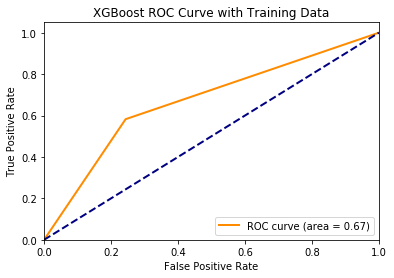

In [105]:
fprt, tprt, _ = roc_curve(Y_train, predictions_train)
roc_auct = auc(fprt, tprt)
plt.figure()
lw = 2
plt.plot(fprt, tprt, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auct)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve with Training Data')
plt.legend(loc="lower right")
plt.show()

Accuracy: 64.88%


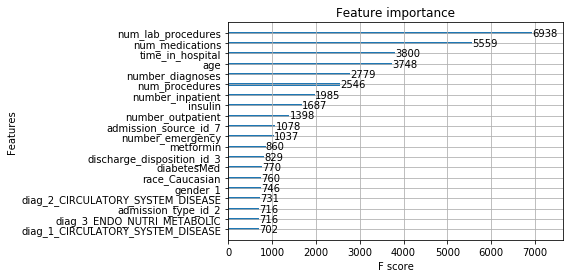

In [103]:
# evaluate predictions accuracy
ypred = model.predict(dtest)
predictions = []
for value in ypred:
    if value <=0.5:
        predictions.append(0)
    else:
        predictions.append(1)
accuracy = sklearn.metrics.accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#importance plot
xgb.plot_importance(model, max_num_features=20)

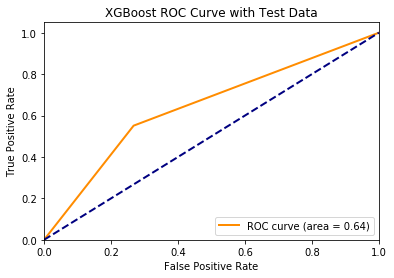

In [104]:
fpr, tpr, thresholds = roc_curve(Y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve with Test Data')
plt.legend(loc="lower right")
plt.show()